In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from helper_functions import plot_loss_curves, compare_historys, create_tensorboard_callback, make_confusion_matrix, load_and_prep_image
style.use('dark_background')

## Data analysis and preprocessing

In [2]:
# check food101 dataset in TFDS
tfds_ds = tfds.list_builders()
print("food101" in tfds_ds)

True


In [2]:
# load our dataset
(train_data, test_data), ds_info= tfds.load(name="food101",
split=["train", "validation"],
shuffle_files=True,
as_supervised=True,
with_info=True)

In [4]:
# check dataset features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [3]:
# get labels
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [19]:
# take a train sample and explore it 
train_sample = train_data.take(1)
train_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [20]:
# get attributes from train sample
for img, lbl in train_sample:
  print(f"""
  image shape: {img.shape}
  image dtype: {img.dtype}
  label form: {lbl}
  class name: {class_names[lbl.numpy()]} 
  """)


  image shape: (489, 512, 3)
  image dtype: <dtype: 'uint8'>
  label form: 90
  class name: spaghetti_bolognese 
  


In [8]:
# check image
img

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [9]:
# check scale
tf.reduce_min(img), tf.reduce_max(img)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

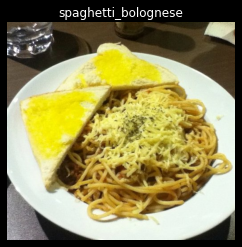

In [21]:
# visualize our images
plt.imshow(img)
plt.title(class_names[lbl])
plt.axis(False);

In [4]:
# create preprocessing function
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float64), label

In [23]:
# test function
prep_img = preprocess_img(img,lbl)[0]
print(f"image before prep:\n {img[0]},\nShape: {img.shape},\ndtype:{img.dtype}\n")
print(f"image after prep:\n {prep_img[0]},\nShape: {prep_img.shape},\ndtype:{prep_img.dtype}")

image before prep:
 [[ 83  71  45]
 [ 81  69  43]
 [ 80  68  44]
 ...
 [186 183 142]
 [188 185 144]
 [185 182 141]],
Shape: (489, 512, 3),
dtype:<dtype: 'uint8'>

image after prep:
 [[8.31085739e+01 7.11085739e+01 4.51085777e+01]
 [8.21116104e+01 7.01116104e+01 4.61116104e+01]
 [8.48732452e+01 7.28732452e+01 4.93018188e+01]
 [8.50000000e+01 7.25000000e+01 5.20000000e+01]
 [8.35915146e+01 6.82343674e+01 5.15915184e+01]
 [8.55220032e+01 6.95220032e+01 5.35220032e+01]
 [8.85491104e+01 7.25491104e+01 5.69575882e+01]
 [8.55833817e+01 7.25833817e+01 5.55833817e+01]
 [8.28008652e+01 6.98008652e+01 5.28008614e+01]
 [7.95553284e+01 6.65553284e+01 4.95553284e+01]
 [8.24787750e+01 6.94787750e+01 5.24787788e+01]
 [8.19263382e+01 6.89263382e+01 5.03549118e+01]
 [7.77634048e+01 6.47633972e+01 4.57633972e+01]
 [8.56859055e+01 7.22633972e+01 5.32633934e+01]
 [8.75483170e+01 7.05483170e+01 5.05483170e+01]
 [9.03954086e+01 7.33954086e+01 5.33954086e+01]
 [8.94768829e+01 7.24768829e+01 5.44768829e+01]
 [

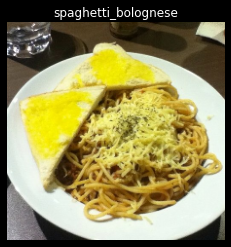

In [24]:
# visualize the sample after prep
plt.imshow(prep_img/255.) 
plt.title(class_names[lbl])
plt.axis(False);

In [14]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [5]:
# Create pipeline to preprocess train and test data
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float64, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float64, tf.int64)>)

## Data modeling

In [26]:
# create callbacks
filename = 'cp-FE.ckpt'
checkpoint_path = os.path.join('checkpoints', filename)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
  monitor="val_accuracy",
  save_best_only=True,
  save_weights_only=True,
  verbose=0)

In [6]:
# enable mixed precision (not supported however it will improve memory utilization)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

Your GPUs may run slowly with dtype policy mixed_float16 because they do not have compute capability of at least 7.0. Your GPUs:
  NVIDIA GeForce GTX 1070 Ti, compute capability 6.1 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPUs may run slowly with dtype policy mixed_float16 because they do not have compute capability of at least 7.0. Your GPUs:
  NVIDIA GeForce GTX 1070 Ti, compute capability 6.1 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [18]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [28]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create feature extraction model
inputs = layers.Input(input_shape, name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

# compile
model.compile(loss="sparse_categorical_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [22]:
# check model layers policy
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [23]:
# check base model layers policy
for layer in model.layers[1].layers[:10]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [29]:
# fit model
history1 = model.fit(train_data,
  epochs=3, 
  steps_per_epoch=len(train_data),
  validation_data=test_data,
  validation_steps=int(0.15*len(test_data)),
  callbacks=[create_tensorboard_callback("logs","exp1"),
  model_checkpoint]
  )

Saving TensorBoard log files to: logs/exp1/20220214-073056
Epoch 1/3


c:\VE\TF\tf2.7\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 291s 119ms/step - loss: 1.8227 - accuracy: 0.5585 - val_loss: 1.2199 - val_accuracy: 0.6822
Epoch 2/3
2368/2368 [==============================] - 279s 117ms/step - loss: 1.2935 - accuracy: 0.6661 - val_loss: 1.1155 - val_accuracy: 0.7023
Epoch 3/3
2368/2368 [==============================] - 280s 118ms/step - loss: 1.1436 - accuracy: 0.7021 - val_loss: 1.0913 - val_accuracy: 0.7071


In [30]:
# save feature extraction model
model.save('models/model_1FE')

INFO:tensorflow:Assets written to: models/model_1FE\assets


INFO:tensorflow:Assets written to: models/model_1FE\assets
c:\VE\TF\tf2.7\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\VE\TF\tf2.7\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [31]:
# Evaluate model of full test_data
Eval_FE = model.evaluate(test_data)
Eval_FE

790/790 [==============================] - 82s 104ms/step - loss: 1.0851 - accuracy: 0.7088


[1.0851390361785889, 0.708752453327179]

**Eval_FE:** <br>
[1.0851390361785889, 0.708752453327179]

In [7]:
# load model
model = tf.keras.models.load_model('models/model_1FE')

In [8]:
# evaluate loaded model
loss_loaded, accuracy_loaded = model.evaluate(test_data)
loss_loaded, accuracy_loaded

790/790 [==============================] - 88s 104ms/step - loss: 1.0851 - accuracy: 0.7088


(1.0851397514343262, 0.708752453327179)

In [30]:
# check dtype policy
mixed_precision.global_policy()

<Policy "mixed_float16">

In [31]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [9]:
# unfreeze layers
model.trainable = True

In [35]:
# check layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [34]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [10]:
# callbacks
earlystop = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=3)

filename = 'cp-FT.ckpt'
checkpoint_path = os.path.join('checkpoints', filename)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
  checkpoint_path,
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
)

reduce_lr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7)


In [11]:
# compile fine tuning model
model.compile(loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

In [12]:
#fit
history2 = model.fit(train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback("logs","exp2"), earlystop, checkpoint, reduce_lr])

Saving TensorBoard log files to: logs/exp2/20220214-111316
Epoch 1/100


c:\VE\TF\tf2.7\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 900s 374ms/step - loss: 0.9213 - accuracy: 0.7531 - val_loss: 0.8210 - val_accuracy: 0.7704 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 879s 371ms/step - loss: 0.5792 - accuracy: 0.8401 - val_loss: 0.8016 - val_accuracy: 0.7828 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 885s 373ms/step - loss: 0.3305 - accuracy: 0.9052 - val_loss: 0.8151 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9483
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 883s 373ms/step - loss: 0.1739 - accuracy: 0.9483 - val_loss: 0.9649 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 886s 374ms/step - loss: 0.0353 - accuracy: 0.9917 - val_loss: 1.0404 - val_accuracy: 0.8067 - lr: 2.0000e-05


In [13]:
# save model
model.save('models/model_2FT')

INFO:tensorflow:Assets written to: models/model_2FT\assets


INFO:tensorflow:Assets written to: models/model_2FT\assets
c:\VE\TF\tf2.7\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\VE\TF\tf2.7\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [14]:
# evaluate model
Eval_FT = model.evaluate(test_data)
Eval_FT

790/790 [==============================] - 85s 107ms/step - loss: 1.0435 - accuracy: 0.8002


[1.04347825050354, 0.8002375960350037]

**Eval_FT:** <br>
[1.04347825050354, 0.8002375960350037]

In [15]:
# load model
model = tf.keras.models.load_model('models/model_2FT')

In [16]:
# evaluate model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 85s 106ms/step - loss: 1.0435 - accuracy: 0.8002


(1.0434783697128296, 0.8002375960350037)

## Model Evalauation

### Evaluation- Tensorboard

In [9]:
# Tensorboard
!tensorboard dev upload --logdir ./logs --name "EfficientNetB0" --description "Comparing TF feature extraction vs finetuning models" --one_shot

^C


In [19]:
# Tensorboard URL:
# https://tensorboard.dev/experiment/J1niNaDRRni8ZzFdJYk4FQ/

### Evaluation- Confusion Matrix

In [20]:
y_true_list = []
y_pred_list = []
for x, y in test_data:
    pred = model.predict(x)
    y_true_list.append(y)
    y_pred_list.append(np.argmax(pred,1))
y_true = tf.concat([i for i in y_true_list],0)
y_pred = tf.concat([i for i in y_pred_list],0)

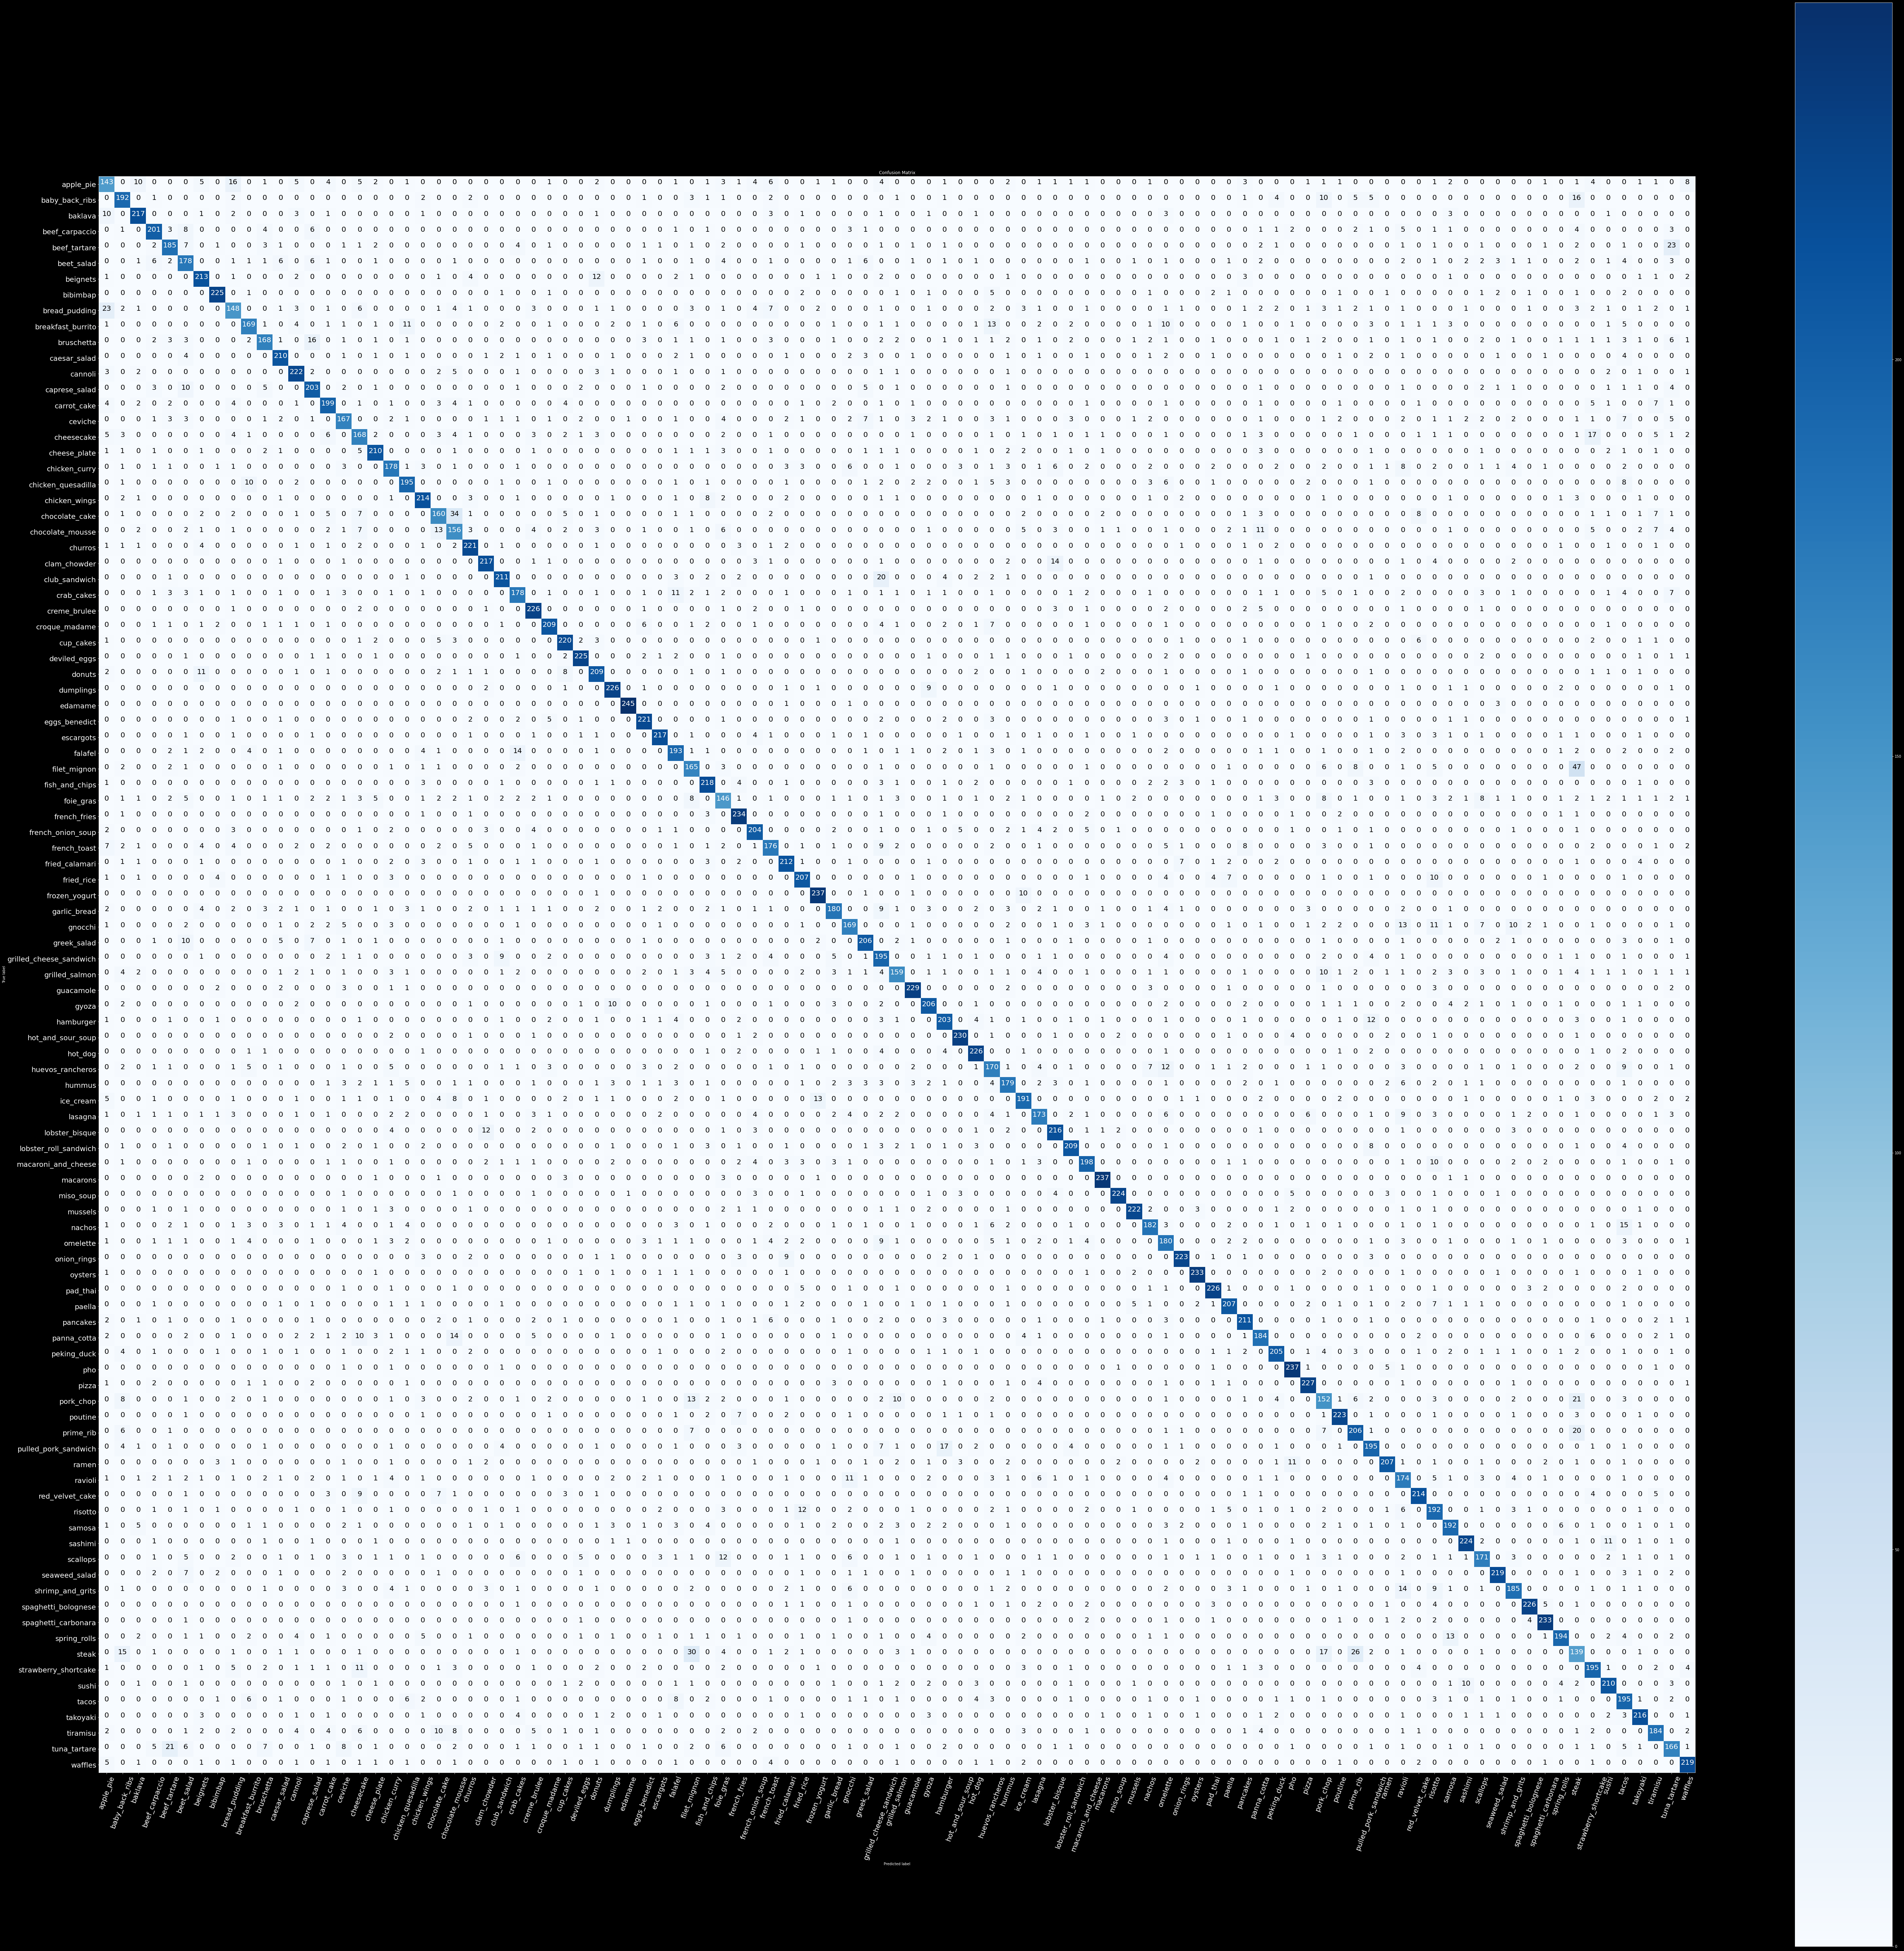

In [21]:
# visualize confusion matrix
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(100,100),text_size=20)

### Evaluation- F1 Scores

In [22]:
# generate classification report dictionary
from sklearn.metrics import classification_report
cr_dict = classification_report(y_true, y_pred, output_dict=True)
cr_dict

{'0': {'precision': 0.6111111111111112,
  'recall': 0.572,
  'f1-score': 0.5909090909090908,
  'support': 250},
 '1': {'precision': 0.7384615384615385,
  'recall': 0.768,
  'f1-score': 0.7529411764705882,
  'support': 250},
 '2': {'precision': 0.84765625,
  'recall': 0.868,
  'f1-score': 0.857707509881423,
  'support': 250},
 '3': {'precision': 0.8271604938271605,
  'recall': 0.804,
  'f1-score': 0.8154158215010143,
  'support': 250},
 '4': {'precision': 0.7644628099173554,
  'recall': 0.74,
  'f1-score': 0.7520325203252033,
  'support': 250},
 '5': {'precision': 0.6544117647058824,
  'recall': 0.712,
  'f1-score': 0.6819923371647508,
  'support': 250},
 '6': {'precision': 0.8068181818181818,
  'recall': 0.852,
  'f1-score': 0.8287937743190661,
  'support': 250},
 '7': {'precision': 0.9183673469387755,
  'recall': 0.9,
  'f1-score': 0.9090909090909091,
  'support': 250},
 '8': {'precision': 0.6727272727272727,
  'recall': 0.592,
  'f1-score': 0.6297872340425531,
  'support': 250},
 '9'

In [23]:
class_names[6]

'beignets'

In [24]:
# extracting F1 scores per class
class_f1 = {}
for k, v in cr_dict.items():
    if k == 'accuracy':
        break
    else:
        class_f1[class_names[int(k)]] = v['f1-score']
class_f1

{'apple_pie': 0.5909090909090908,
 'baby_back_ribs': 0.7529411764705882,
 'baklava': 0.857707509881423,
 'beef_carpaccio': 0.8154158215010143,
 'beef_tartare': 0.7520325203252033,
 'beet_salad': 0.6819923371647508,
 'beignets': 0.8287937743190661,
 'bibimbap': 0.9090909090909091,
 'bread_pudding': 0.6297872340425531,
 'breakfast_burrito': 0.7316017316017316,
 'bruschetta': 0.7288503253796096,
 'caesar_salad': 0.8383233532934131,
 'cannoli': 0.8505747126436781,
 'caprese_salad': 0.79296875,
 'carrot_cake': 0.7944111776447106,
 'ceviche': 0.6858316221765913,
 'cheesecake': 0.6679920477137178,
 'cheese_plate': 0.8467741935483871,
 'chicken_curry': 0.726530612244898,
 'chicken_quesadilla': 0.7942973523421588,
 'chicken_wings': 0.8425196850393701,
 'chocolate_cake': 0.6779661016949153,
 'chocolate_mousse': 0.6141732283464567,
 'churros': 0.8532818532818534,
 'clam_chowder': 0.8714859437751004,
 'club_sandwich': 0.8525252525252526,
 'crab_cakes': 0.7370600414078674,
 'creme_brulee': 0.865900

In [25]:
# organizing F1 scores in DataFrame (sorted)
f1_scores= pd.DataFrame({"class_name": list(class_f1.keys()),"f1_score": list(class_f1.values())}).sort_values('f1_score', ascending=False)
f1_scores

,class_name,f1_score
33,edamame,0.983936
63,macarons,0.946108
69,oysters,0.939516
64,miso_soup,0.927536
54,hot_and_sour_soup,0.927419
...,...,...
22,chocolate_mousse,0.614173
77,pork_chop,0.601980
39,foie_gras,0.595918
0,apple_pie,0.590909


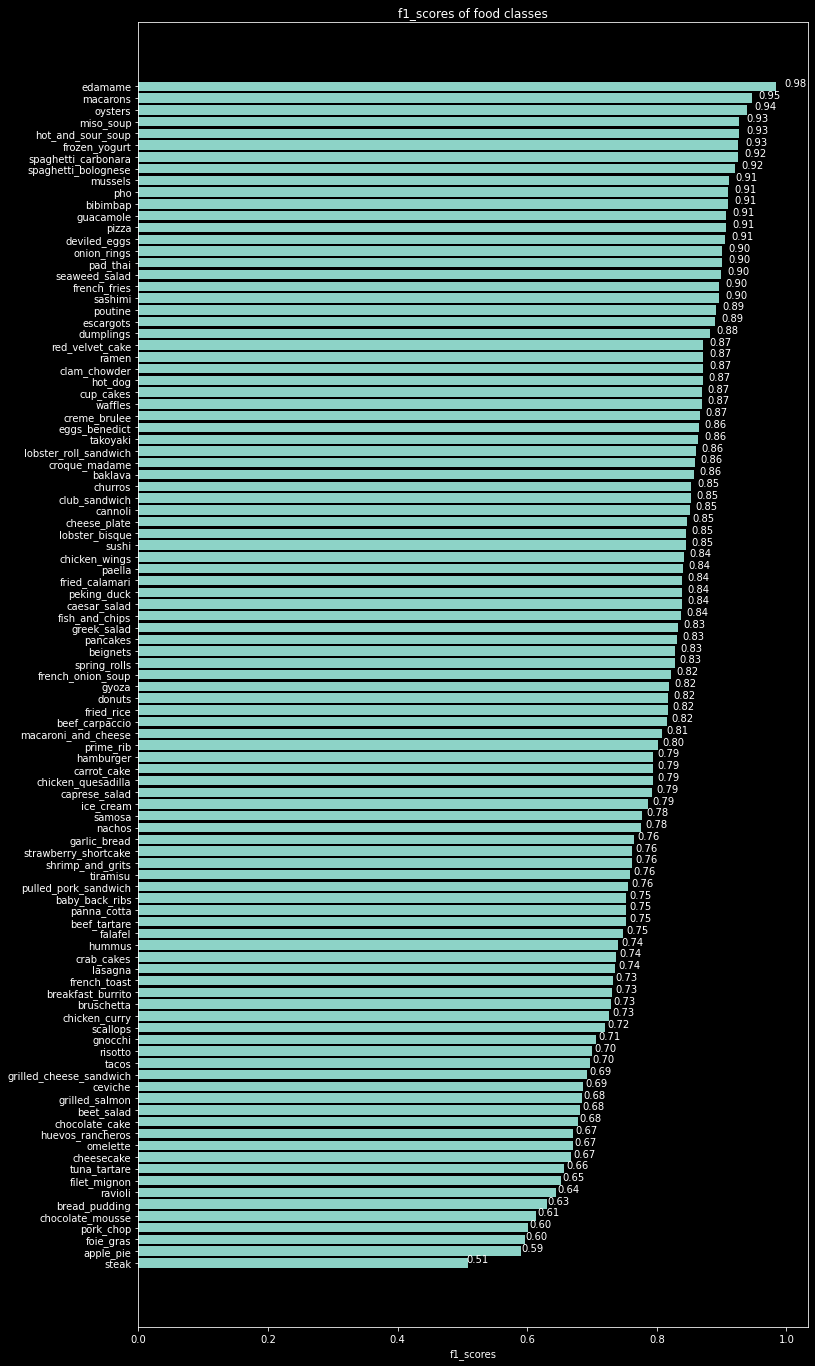

In [26]:
# plotting f1 scores
def score_label(labels): 
    for label in labels:
        width = label.get_width()
        ax.text(1.03*width, label.get_y() + label.get_height()/1.5,
        f"{width:.2f}",
        ha='center', va='bottom')

fig, ax= plt.subplots(figsize=(12,24))
labels = ax.barh(range(len(f1_scores)), list(f1_scores['f1_score']))
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_name'].values)
ax.set_xlabel('f1_scores')
ax.set_title('f1_scores of food classes')
ax.invert_yaxis()
score_label(labels)